# Parkinson's Detection with SPIRAL Diagram

In [38]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [1]:
!ls 

Augumented_data                 spiral_basic_model.ipynb
Original_data                   spiral_healthy_augumentor.py
data                            spiral_intermidiate_model.ipynb
model.h5                        spiral_parkinson_augumentor.py
model.json                      wave_basic_model.ipynb
spiral


In [3]:
plt.style.use('dark_background')

In [4]:
cur_dir = os.getcwd()

healthy_path = os.path.join(cur_dir, 'spiral/healthy')
parkinson_path = os.path.join(cur_dir, 'spiral/parkinson')


# Data Visulization

### Healthy Wave

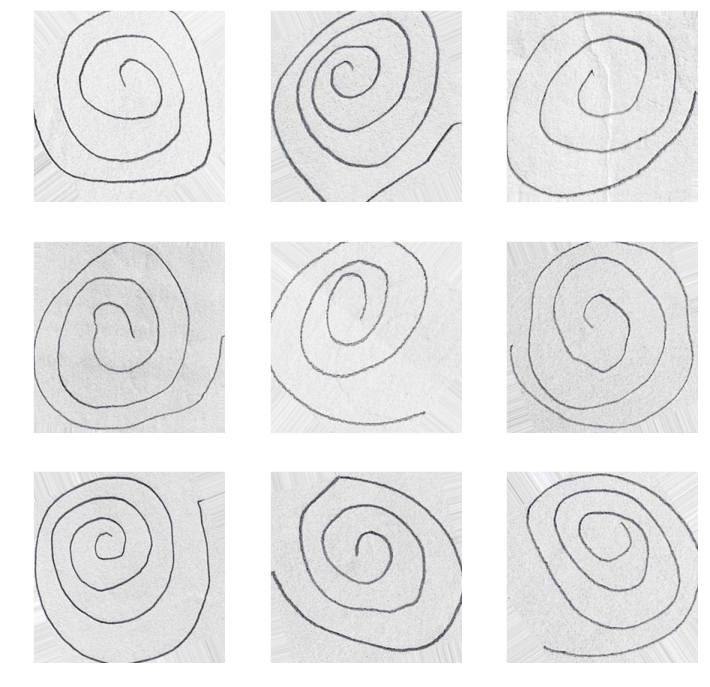

In [7]:
plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    name = os.listdir(healthy_path)[i]
    img_path = os.path.join(healthy_path, name)
    img = load_img(img_path)
    plt.imshow(img)   
plt.show() 

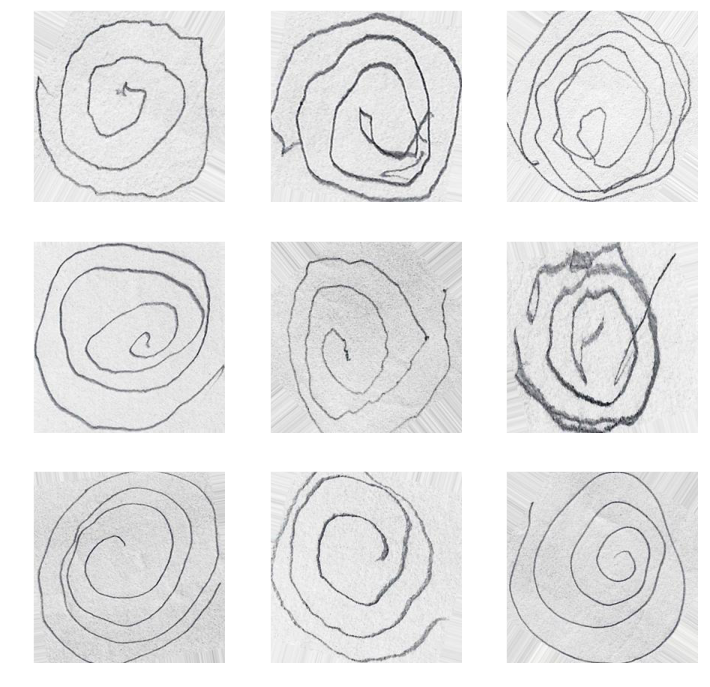

In [8]:
plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    name = os.listdir(parkinson_path)[i]
    img_path = os.path.join(parkinson_path, name)
    img = load_img(img_path)
    plt.imshow(img)   
plt.show() 

## Loading Data

In [10]:
data = tf.keras.utils.image_dataset_from_directory('spiral')

Found 5089 files belonging to 2 classes.


2022-06-23 19:49:00.008756: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

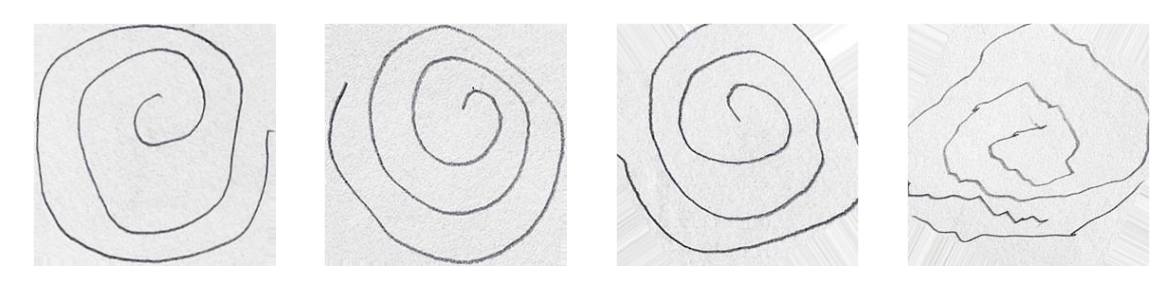

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Converting pixel between 0 to 1

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.90588236, 0.90588236, 0.90588236],
          [0.90588236, 0.90588236, 0.90588236],
          [0.9098039 , 0.9098039 , 0.9098039 ],
          ...,
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.8901961 , 0.8901961 , 0.8901961 ],
          [0.89411765, 0.89411765, 0.89411765]],
 
         [[0.8862745 , 0.8862745 , 0.8862745 ],
          [0.8862745 , 0.8862745 , 0.8862745 ],
          [0.8862745 , 0.8862745 , 0.8862745 ],
          ...,
          [0.9098039 , 0.9098039 , 0.9098039 ],
          [0.8901961 , 0.8901961 , 0.8901961 ],
          [0.89411765, 0.89411765, 0.89411765]],
 
         [[0.8784314 , 0.8784314 , 0.8784314 ],
          [0.8784314 , 0.8784314 , 0.8784314 ],
          [0.8745098 , 0.8745098 , 0.8745098 ],
          ...,
          [0.90588236, 0.90588236, 0.90588236],
          [0.8901961 , 0.8901961 , 0.8901961 ],
          [0.8980392 , 0.8980392 , 0.8980392 ]],
 
         ...,
 
         [[0.8901961 , 0.8901961 , 0.8901961 ],
          [0.89019

## Splitting Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Building the MODEL

In [31]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 128)     

In [32]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [tensorboard_callback,reduce_learningrate]

In [33]:
model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])

In [34]:
history = model.fit(
        train,
        epochs = 3,
        validation_data = val,
        callbacks=reduce_learningrate)

Epoch 1/3
112/112 [==============================] - 163s 1s/step - loss: 0.7256 - accuracy: 0.5321 - val_loss: 0.6389 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 2/3
112/112 [==============================] - 165s 1s/step - loss: 0.5123 - accuracy: 0.7486 - val_loss: 0.3536 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 3/3
112/112 [==============================] - 161s 1s/step - loss: 0.3142 - accuracy: 0.8669 - val_loss: 0.2036 - val_accuracy: 0.9209 - lr: 0.0010


/var/folders/ts/4y5v3zns7x5c84jf9byws_nc0000gn/T/ipykernel_3182/118622353.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', label='Training acc', color = 'red')
/var/folders/ts/4y5v3zns7x5c84jf9byws_nc0000gn/T/ipykernel_3182/118622353.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training loss', color = 'red')


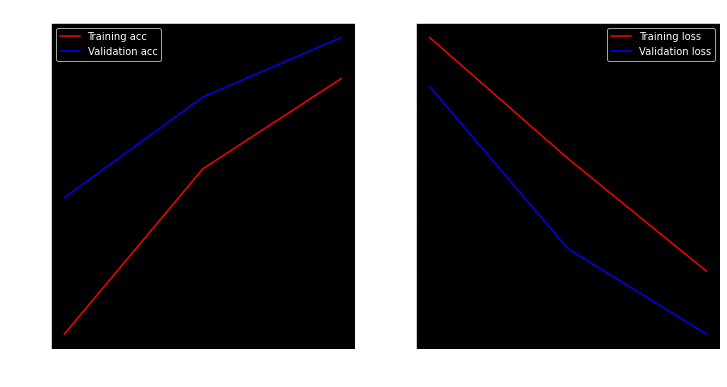

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc', color = 'red')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training loss', color = 'red')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model Evaluate

In [37]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.86545455, shape=(), dtype=float32) tf.Tensor(0.97540987, shape=(), dtype=float32) tf.Tensor(0.9160156, shape=(), dtype=float32)


## Testing 

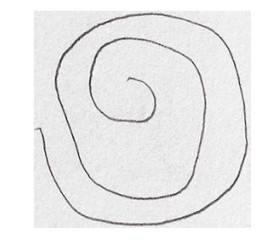

In [40]:
img_path = os.path.join(cur_dir, 'spiral/healthy/healthy_V01HE01_0_1119.jpg')

img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

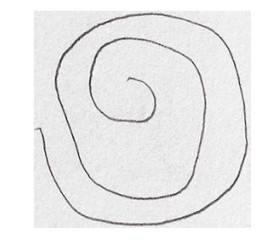

In [41]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [65]:
prediction = model.predict(np.expand_dims(resize/255, 0))

print(prediction)

[[0.04853407]]


### Key 
 
### 0 --> Healthy
### 1 --> Parkinson

In [66]:
if prediction < 0.5: 
    print(f'The person is Healthy')
else:
    print(f'The person may have parkinson')

The person is Healthy


## Saving the MODEL


In [68]:
from tensorflow.keras.models import load_model

# model.save(os.path.join('models','3_spiral_model.h5'))  # USE THIS TO SAVE MODEL
new_model = load_model('models/3_spiral_model.h5')

In [69]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.04853407]], dtype=float32)